### HW4<br/>
Motahare Hazrati<br/>
400206613<br/>


In [1]:
!pip install -q transformers
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout, Input
from tqdm import tqdm
import pickle
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
import itertools
from sklearn.utils import shuffle
from tensorflow.keras import regularizers
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 82.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.0 MB/s eta 0:00:00


/usr/local/lib/python3.8/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(


In [11]:
def read_file(path, label):
    df = pd.read_csv(path, delimiter = "\n", names=["text", 'label'])
    df['label'] = label
    return df
def create_model():
    inps = Input(shape = (leng,), dtype='int64')
    masks= Input(shape = (leng,), dtype='int64')
    dbert_layer = modell(inps, attention_mask=masks)[0][:,0,:]
    pred = Dense(10, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dbert_layer)
    model = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    print(model.summary())
    return model   

def plot_history(history):
    plt.figure(figsize=(20,10))
    plt.subplot(1, 2, 1)
    plt.suptitle('Optimizer : Adam', fontsize=30)
    plt.ylabel('Loss', fontsize=16)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.ylabel('Accuracy', fontsize=16)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.show()
    
def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



In [3]:


df_abusaeed = read_file('abusaeed_stp_rmv.txt', 'abusaeed')
df_fer = read_file('amir_stp_rmv.txt', 'amir')
df_anvari = read_file('anvari_stp_rmv.txt', 'anvari')
df_asad = read_file('asad_stp_rmv.txt', 'asad')
df_khayam = read_file('asadi_stp_rmv.txt', 'asadi')
df_manoch = read_file('attar_stp_rmv.txt', 'attar')
df_moulavi = read_file('moulavi_stp_rmv.txt', 'moulavi')
df_parvin = read_file('parvin_stp_rmv.txt', 'parvin')
df_saeb = read_file('saeb_stp_rmv.txt', 'saeb')
df_sanaee = read_file('sanaee_stp_rmv.txt', 'sanaee')



dframe = pd.concat([df_abusaeed, df_fer,df_anvari,df_asad,df_khayam,df_manoch,df_moulavi,df_parvin,df_saeb,df_sanaee], ignore_index=True)
df = dframe.sample(frac=1).reset_index(drop=True)
df.head(20)


,text,label
0,سنگ نگردد سختی طلب,saeb
1,میخواره رند هرزه گردم,abusaeed
2,ازو ایمان دین,attar
3,بیهده سویی,attar
4,صدهزاران پرده نا,sanaee
5,خوانند قلب راکه,attar
6,مغز فضل حکم محض معالی,anvari
7,خدایی عین نمودار,attar
8,آدم مقصود عالم,attar
9,امن تشویش حضور غیبت طغرل تکین,anvari


In [6]:
from transformers import BertConfig
from transformers import TFBertForPreTraining
model_name = "HooshvareLab/bert-fa-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
Config = BertConfig.from_pretrained(model_name)
modell = TFBertForPreTraining(Config)

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--HooshvareLab--bert-fa-base-uncased/snapshots/a04aa40c97bcdde570ae11986a534542c2995a62/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--HooshvareLab--bert-fa-base-uncased/snapshots/a04aa40c97bcdde570ae11986a534542c2995a62/config.json
Model config BertConfig {
  "_name_or_path": "HooshvareLab/bert-fa-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--HooshvareLab--bert-fa-base-uncased/snapshots/a04aa40c97bcdde570ae11986a534542c2

In [9]:

textt=df['text']
labels=df['label']
leng=32
inpp=tokenizer.encode_plus(textt[0],add_special_tokens = True,lenggth =20,pad_to_lenggth = True,truncation=True)
tokenizer.tokenize(textt[10])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Keyword arguments {'lenggth': 20, 'pad_to_lenggth': True} not recognized.


['نان', 'خورند', '##ی', 'دختران', 'خاطرم']

In [10]:
id_inp=np.asarray(inpp['input_ids'])
mask_inp=np.asarray(inpp['attention_mask'])
out=modell([id_inp.reshape(1,-1),mask_inp.reshape(1,-1)])
type(out),out
tokenizer.decode(inpp['input_ids'])

'[CLS] سنگ نگردد سختی طلب [SEP]'

###  Create BERT MODEL  ###

In [13]:
model=create_model()
model.layers[2].trainable=False


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 tf_bert_for_pre_training (TFBe  TFBertForPreTrainin  163535010  ['input_3[0][0]',                
 rtForPreTraining)              gOutput(loss=None,                'input_4[0][0]']                
                                prediction_logits=(                                               
                                None, 32, 100000),                                          

bert freezed

In [14]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 tf_bert_for_pre_training (TFBe  TFBertForPreTrainin  163535010  ['input_3[0][0]',                
 rtForPreTraining)              gOutput(loss=None,                'input_4[0][0]']                
                                prediction_logits=(                                               
                                None, 32, 100000),                                          

In [ ]:
input_ids=[]
attention_masks=[]

for sent in textt:
    inpps=tokenizer.encode_plus(sent,add_special_tokens = True,lenggth =leng,pad_to_lenggth = True,return_attention_mask = True,truncation=True)
    input_ids.append(inpps['input_ids'])
    attention_masks.append(inpps['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

In [ ]:
callbacks= [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

model.compile(loss=loss,optimizer=optimizer, metrics=[metric])

it was going to be trained

In [ ]:
history=model.fit([train_inp,train_mask],train_label,batch_size=16,epochs=2,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)

Epoch 1/2


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


12790/25005 [==============>...............] - ETA: 15:41 - loss: 1.9990 - accuracy: 0.3272

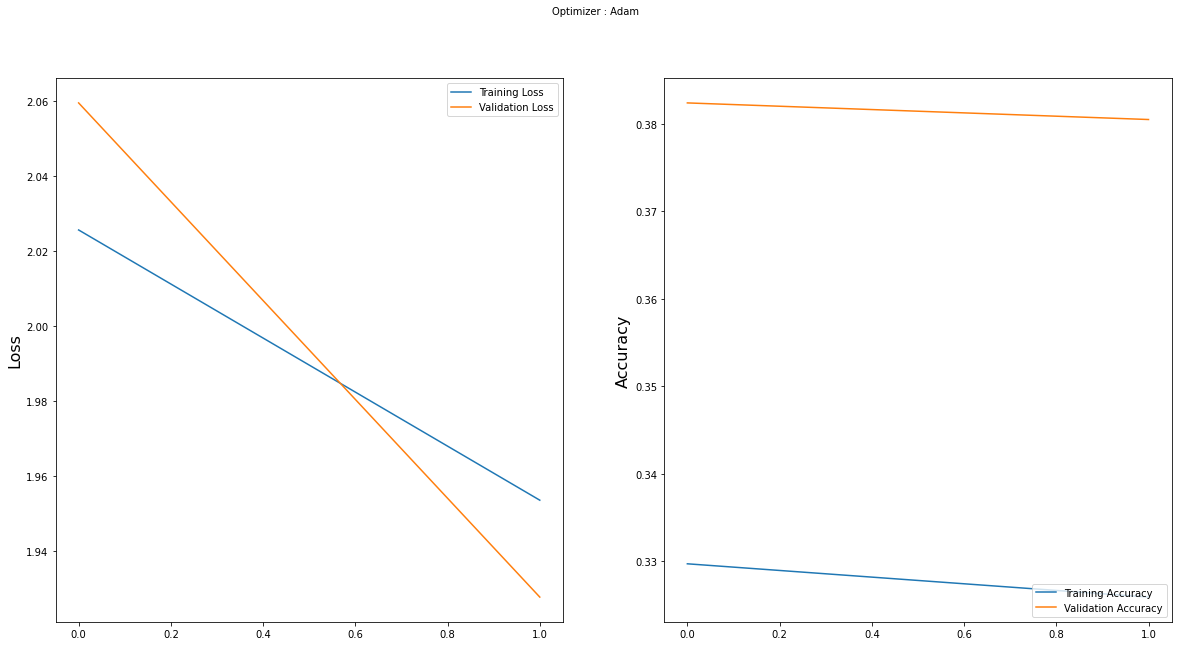

In [ ]:
plot_history(history)

### Confusion Matrix

<Figure size 432x288 with 0 Axes>

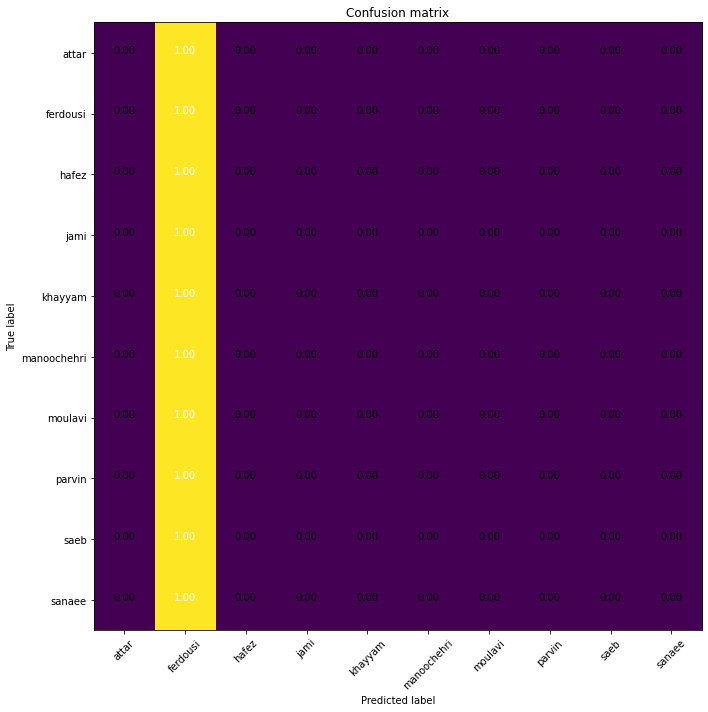

In [ ]:

predictions = model.predict([val_inp,val_mask])
y_pred = [np.argmax(probas) for probas in predictions]
cnf_matrix = confusion_matrix(val_label, y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
class_names = ['abusaeed', 'amir', 'anvari','asad', 'asadi', 'attar','moulavi', 'parvin', 'saeb','sanaee']
plot_confusion_matrix(cnf_matrix, classes=class_names)
plt.show()

### Micro F1 score 

In [ ]:
micro_f1 = f1_score(val_label,y_pred,average='micro')
micro_f1

0.05512641314030374

### Fine Tune

### fine tuning whole model with ADAM optimizer

In [ ]:
from transformers import BertConfig
from transformers import TFBertForPreTraining

Config = BertConfig.from_pretrained("HooshvareLab/bert-fa-base-uncased")
modell = TFBertForPreTraining(Config)

model=create_model()


callbacks= [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

model.compile(loss=loss,optimizer=optimizer, metrics=[metric])


history_fn_Adam=model.fit([train_inp,train_mask],train_label,batch_size=16,epochs=2,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)


#Plot loss and accuracy


plot_history(history_fn_Adam)



#Prediction
predictions = model.predict([val_inp,val_mask])
y_pred = [np.argmax(probas) for probas in predictions]

cnf_matrix = confusion_matrix(val_label, y_pred)
np.set_printoptions(precision=2)



# plot normalized confusion matrix
plt.figure()
class_names = ['abusaeed', 'amir', 'anvari','asad', 'asadi', 'attar','moulavi', 'parvin', 'saeb','sanaee']
plot_confusion_matrix(cnf_matrix, classes=class_names)
plt.show()


#Micro F1

micro_f1 = f1_score(val_label,y_pred,average='micro')
micro_f1

### fine tuning whole model with SGD optimizer

In [ ]:
from transformers import BertConfig
from transformers import TFBertForPreTraining

Config = BertConfig.from_pretrained("HooshvareLab/bert-fa-base-uncased")
modell = TFBertForPreTraining(Config)

model=create_model()


callbacks= [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-5)

model.compile(loss=loss,optimizer=optimizer, metrics=[metric])


history_fn_SGD=model.fit([train_inp,train_mask],train_label,batch_size=16,epochs=2,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)


#Plot loss and accuracy


plot_history(history_fn_SGD)



#Prediction
predictions = model.predict([val_inp,val_mask])
y_pred = [np.argmax(probas) for probas in predictions]

cnf_matrix = confusion_matrix(val_label, y_pred)
np.set_printoptions(precision=2)



# plot normalized confusion matrix
plt.figure()
class_names = ['abusaeed', 'amir', 'anvari','asad', 'asadi', 'attar','moulavi', 'parvin', 'saeb','sanaee']
plot_confusion_matrix(cnf_matrix, classes=class_names)
plt.show()


#Micro F1

micro_f1 = f1_score(val_label,y_pred,average='micro')
micro_f1